# Exercises

## 1. 97% accuracy
#### Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the `KNeighborsClassifier` works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters.

In [42]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Flatten x_train
x_train = x_train.reshape(-1, 784)

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [3]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'weights': ['uniform', 'distance']},
    {'n_neighbors': ['4', '6', '8']}
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=1, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TypeError: '<' not supported between instances of 'str' and 'int'

In [5]:
# Saving model
from sklearn.externals import joblib

joblib.dump(knn_clf, 'best_knn.pkl')

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['best_knn.pkl']

## 2. Data Augmentation
#### Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artifically growing the training set is called **data augmentation** or **training set expansion.**

In [9]:
# Let's evaluate how the knn_clf does without the data augmentation
from sklearn.metrics import accuracy_score

pred = knn_clf.predict(x_test.reshape(-1,784))
accuracy_score(y_test, pred)

0.9688

In [95]:
import numpy as np
from scipy.ndimage.interpolation import shift

x_train_aug = np.empty((60000*2,784), dtype='uint8')
y_train_aug = np.empty((60000*2,1), dtype='uint8')
for c in range(len(x_train)-1):
    try:
        x_train_aug[c] = x_train[c]
        y_train_aug[c] = y_train[c]
        x_train_aug[c+1] = shift([x_train[c]], [1,0])
        y_train_aug[c+1] = y_train[c]
    except:
        pass


#x_train = np.concatenate( (x_train,shift(x_train, [1,0]),shift(x_train, [-1,0]),
#                shift(x_train, [0,-1]), shift(x_train, [0,1])) )

#x_train_aug = np.concatenate((x_train, right, left, down, up))
#y_train_aug = np.repeat(y_train, 5)

In [96]:
print(x_train_aug.shape, y_train_aug.shape)

(120000, 784) (120000, 1)


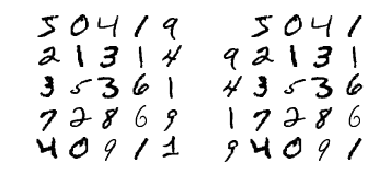

In [97]:
import matplotlib.pyplot as plt

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

%matplotlib inline
plt.subplot(121)
plot_digits(x_train_aug[:25], images_per_row=5)
plt.subplot(122)
plot_digits(x_train_aug[60000:60025], images_per_row=5)

In [111]:
i = 10

print(y_train_aug[60000*0+i],y_train_aug[60000*1+i])

[3] [127]


In [11]:
shuffle_index = np.random.permutation(x_train_aug.shape[0])
x_train_aug, y_train_aug = x_train_aug[shuffle_index], y_train_aug[shuffle_index]

In [12]:
print(x_train_aug.shape, y_train_aug.shape)

(300000, 784) (300000,)


In [14]:
knn_clf.fit(x_train_aug, y_train_aug)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [15]:
pred_aug = knn_clf.predict(x_test.reshape(-1,784))
accuracy_score(y_test, pred_aug)

0.1036

## 3. Tackle the Titanic dataset.

In [233]:
import pandas as pd
train, test = pd.read_csv('titanic/train.csv'), pd.read_csv('titanic/test.csv')
train_y = train['Survived']
train = train.drop(['Survived'], axis=1)

In [234]:
train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [116]:
train.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

The cabin attribute is missing about 3/4 of it's data! I think we should just drop the attribute all together. However, age is not missing too much, so let's just use a Impeter to replace with the median.

In [119]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [122]:
numerical = train.drop(['PassengerId','Survived','Pclass','Name','Sex','Ticket','Cabin','Embarked'], axis=1)
numerical.head()

,Age,SibSp,Parch,Fare
0,22.0,1,0,7.2500
1,38.0,1,0,71.2833
2,26.0,0,0,7.9250
3,35.0,1,0,53.1000
4,35.0,0,0,8.0500


In [146]:
categorical = train.drop(['PassengerId','Survived','Name','Age','SibSp','Parch','Ticket','Fare','Cabin'], axis=1)
categorical.dropna()
categorical.head()

,Pclass,Sex,Embarked
0,3,male,S
1,1,female,C
2,3,female,S
3,1,female,S
4,3,male,S


In [197]:
# DataFrameSelector to facilitate pipelines
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class DropNA(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        new = np.array([])
        for r in range(X.shape[0]):
            if not np.any(pd.isnull(X[r])):
                np.append(new,X[r], axis=0)
        return new

In [201]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_attributes = ['Age','SibSp','Parch','Fare']
cat_attributes = ['Pclass','Sex','Embarked']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', imputer),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attributes)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder())
])

In [202]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [204]:
train_prepared = full_pipeline.fit_transform(train)
train_prepared.shape

(891, 12)

In [216]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(train_prepared, train_y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [217]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(train_prepared, train_y)

C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [218]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


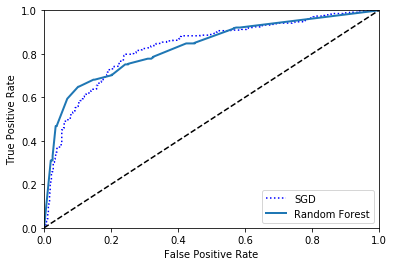

In [220]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

y_scores_sgd = cross_val_predict(sgd_clf, train_prepared, train_y, cv=3, method='decision_function')
y_probas_forest = cross_val_predict(forest_clf, train_prepared, train_y, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:,1]

sgd_fpr, sgd_tpr, sgd_thresholds = roc_curve(train_y, y_scores_sgd)
forest_fpr, forest_tpr, forest_thresholds = roc_curve(train_y, y_scores_forest)

plt.plot(sgd_fpr, sgd_tpr, 'b:', label='SGD')
plot_roc_curve(forest_fpr, forest_tpr, label='Random Forest')
plt.legend(loc='lower right')

In [222]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, train_prepared, train_y, cv=3, scoring='accuracy')

array([0.76094276, 0.74410774, 0.81144781])

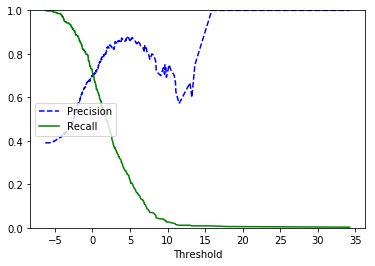

In [224]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, train_prepared, train_y, cv=3, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(train_y, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Let's do a precision of 80%, with a threshold of 2.5

Text(0,0.5,'Precision')

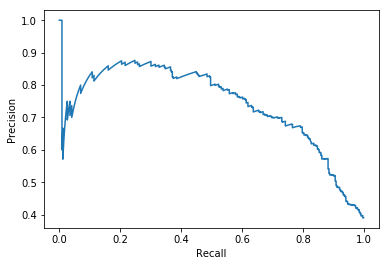

In [226]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [227]:
y_train_pred_80 = (y_scores > 2.5)

In [228]:
from sklearn.metrics import recall_score, precision_score

print(precision_score(train_y, y_train_pred_80), recall_score(train_y, y_train_pred_80))

0.8342857142857143 0.4269005847953216


In [230]:
y_train_pred_80 = (y_scores > 2.3)

In [231]:
from sklearn.metrics import recall_score, precision_score

print(precision_score(train_y, y_train_pred_80), recall_score(train_y, y_train_pred_80))

0.8342245989304813 0.45614035087719296


Let's look at the confusion matrix

In [232]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_y, y_train_pred_80)

array([[518,  31],
       [186, 156]], dtype=int64)

## 4. Build a spam classifer.

In [240]:
# Downloading data
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://spamassassin.apache.org/old/publiccorpus/'
FILEPATH = os.path.join('datasets','spam')
FILES = ['20021010_easy_ham.tar.bz2', '20021010_hard_ham.tar.bz2', '20021010_spam.tar.bz2',
         '20030228_easy_ham.tar.bz2', '20030228_easy_ham_2.tar.bz2', '20030228_hard_ham.tar.bz2',
         '20030228_spam.tar.bz2', '20030228_spam_2.tar.bz2', '20050311_spam_2.tar.bz2']

def fetch_data(download_root=DOWNLOAD_ROOT, files=FILES, filepath=FILEPATH):
    if not os.path.isdir(filepath):
        os.makedirs(filepath)
    for file in files:
        bz2_path = os.path.join(filepath,file)
        urllib.request.urlretrieve(os.path.join(download_root,file), bz2_path)
        spam_bz2 = tarfile.open(bz2_path, 'r:bz2')
        spam_bz2.extractall(path=filepath)
        spam_bz2.close()

fetch_data()